# Subsetting waveform lidar

Import Libraries

In [1]:
import numpy as np
import time
from matplotlib import pyplot as plt
import NEON_AOP_waveform_tools
import csv
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D

NEON_AOP_waveform_tools is a python script, written by Tristen, which will be available on the NEON github site. 

To unzip plz files you can use the pulsewaves tool, which is available for download [here](https://rapidlasso.com/pulsewaves/)

To unzip we did this step in command line, but here's the syntax: 

`cd C:\pulsewavesDLL\pulsewavesDLL`

`pulse2pulse -i ".\RSDI-2018\capstone\data\Pulsewaves\NEON_D03_OSBS_DP1_L014-1_2017092713_translate.plz" -opls`

Then, load file

In [2]:
PlsFile = r"C:\Users\Amanda Schwantes\Documents\RSDI-2018\capstone\data\PR\NEON_D04_GUIL_DP1_L009-1_2018052110_translate_1.pls"

#PlsFile = r"C:\Users\Amanda Schwantes\Documents\RSDI-2018\data\NEON-Fri\WaveformLidar\2015032618_Q780_150326_194954_1_originalpoints.pls"

To loop through all the pulses within the file, we need to determine the number of pulses.

In [3]:
#Determine number of pulses
fin_pls_file = open(PlsFile,"rb")
fin_pls_file.seek(184,0)
number_of_pulses = np.fromfile(fin_pls_file,np.int64,1)
number_of_pulses = number_of_pulses[0]
print(number_of_pulses)

7692085


Here we are looping through multiple pulses within the file. For each pulse, we are running a Gaussian decomposition, using the Levenberg–Marquardt algorithm. For each detected peak, we are finding the full width half max point (e.g. the leading edge). 

In [4]:
GaussianCalcTime = time.clock()
tot_peaks_old=0

pulses = np.arange(1,10)

xyz_coords = []
xyz_coords = np.zeros((10000*10,5)) # make a lot of rows... (max 7 peaks per pulse)

for pulse in pulses:
    
    #num_peaks_in = []
    
    pulse=[pulse]
    # Read in pulse number info
    # 1) coordinate info
    # 2) received wave
    # 3) outgoing wave
    coord_info, wave_in, wave_out = NEON_AOP_waveform_tools.waveform_read(pulse,PlsFile)
    # print coordinates
    #print(coord_info) # first number is GPS time, next 3 describe the direction of the (3d coordinates), 
    # last three number are the actual coordinates the start of the pulse (x,y,z)
    
    initial_params_out = NEON_AOP_waveform_tools.get_params(wave_out[0])
    initial_params_in = NEON_AOP_waveform_tools.get_params(wave_in[0])
    
    if (initial_params_in.sum() > 0):
    
        num_peaks_in = np.array(initial_params_in[0,-1]) # number of peaks is saved in this location

        #WFtime = np.arange(1,244) # set up time (ns bins)

        #fit_wave_final = NEON_AOP_waveform_tools.get_fit_wave(initial_params_in, 244, num_peaks_in)

        temp_out_params = NEON_AOP_waveform_tools.get_gaussian_params(initial_params_out,wave_out[0],10,20,0)[0]

        temp_in_params = NEON_AOP_waveform_tools.get_gaussian_params(initial_params_in,wave_in[0],10,20,0)[0]

        fit_wave_final = NEON_AOP_waveform_tools.get_fit_wave(temp_in_params,244,num_peaks_in)

        FWHM = (2.355*(initial_params_in[0,2:int(num_peaks_in*3):3]/2**0.5))/2 # full width half max. Grab 3rd, 6th, 9th parameters

        #trig_loc = initial_params_in[0,1:int(num_peaks_in*3):3] - FWHM
        #trig_loc  = np.reshape(trig_loc,(int(num_peaks_in),1))

        # normalize trigger locations by the location of the outgoing pulse
        # trig_loc = initial_params_in[0,1:int(num_peaks_in*3):3]-FWHM-initial_params_out[0,1]
        # trig_loc = np.reshape(trig_loc,(int(num_peaks_in),1))

        trig_loc = temp_in_params[0,1:int(num_peaks_in*3):3]-FWHM-temp_out_params[0,1]
        trig_loc = np.reshape(trig_loc,(int(num_peaks_in),1))

        pulse_coords = (np.matlib.repmat(trig_loc[:,0],3,1)).transpose()*coord_info[:,1:4]+coord_info[:,4:7]
        #print(pulse_coords)

        tot_peaks_new = tot_peaks_old + num_peaks_in
        #print(tot_peaks_new)
        
        for k in np.arange(int(tot_peaks_old), int(tot_peaks_new)):
            #print(k)
            xyz_coords[k,0:3] = pulse_coords[:,0:3][k-int(tot_peaks_old)]
            xyz_coords[k,4] = k-int(tot_peaks_old)
            xyz_coords[k,3] = pulse[0]
            #print(pulse[0])
            
        tot_peaks_old = tot_peaks_new
        #print(type(pulse[0]))
    
print('Total time is {}'.format(time.clock()-GaussianCalcTime))

xyz_coordsDF = pd.DataFrame(data=xyz_coords,
                columns=['x','y','z','pulse','return'])  # 1st row as the column names

xyz_coordsDF.to_csv('../output/waveformXYZ_0714_2018.csv', sep=',')

1
Total time is 2.2562077681159423


We then read in the csv file that we created. This one, only has 10 processed pulses, but we processed 10,000 originally. We then plot the return coordinates from the waveform lidar in 3D. 

UTM x min: 733720.2060559744and max: 734414.4858104966
UTM y min: 2011741.7231886375and max: 2011846.2517685469


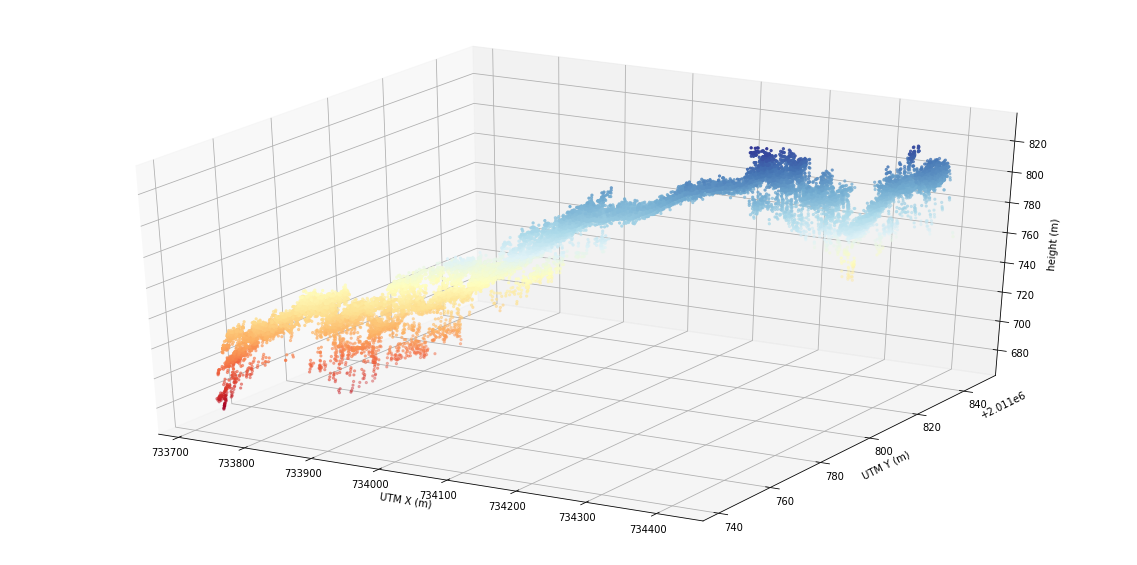

In [5]:
xyz_coordsDF = pd.read_csv('../output/waveformXYZ_0713_2018c.csv', sep=',')

indexNZ = xyz_coordsDF["x"].nonzero()[0][-1]

#this removes empty zero rows.
xyz_coords = np.array(xyz_coordsDF)

xyz_coords2 = xyz_coords[0:indexNZ,:]

#This one removes birds (errors)
indexLow = np.where(xyz_coords2[:,3] < 1200)

xyz_coords3 = xyz_coords2[indexLow,:][0]

fig = plt.figure(figsize = (20,10))
ax = fig.add_subplot(111, projection='3d')

cm = plt.cm.get_cmap('RdYlBu')

sc = ax.scatter(xyz_coords3[:,1], xyz_coords3[:,2], xyz_coords3[:,3], c=xyz_coords3[:,3], marker='.', cmap = cm, s = 20)

ax.set_xlabel('UTM X (m)')
ax.set_ylabel('UTM Y (m)')
ax.set_zlabel('height (m)')

plt.savefig('../output/WaveformProfile.png')

#this prints the UTMS so we can find them later
print('UTM x min: ' + str(np.amin(xyz_coords2[:,1])) + 'and max: ' + str(np.amax(xyz_coords2[:,1])))
print('UTM y min: ' + str(np.amin(xyz_coords2[:,2])) + 'and max: ' + str(np.amax(xyz_coords2[:,2])))
